In [1]:
from datetime import datetime
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])

api_dir = str(curr_dir)
if api_dir not in sys.path:
    sys.path.insert(0, api_dir)
    

import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.model.classifier import Classifier
from src.datasets.ECG200 import ECG200
from src.model.explainer import explain_samples
from src.model.sample_explainers.gradient_shap import ShapGradientExplainer
from src.utils.dataset_creator import load_dataset

2021-11-09 16:09:08.576441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-09 16:09:08.576455: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load dataset
dataset from https://www.timeseriesclassification.com/description.php?Dataset=ECG200

In [2]:
train, valid, test = load_dataset(creator=ECG200(),
                                  data_path=Path(api_dir) / "src/datasets/ECG200")

2021-11-09 16:09:19.906265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-09 16:09:19.906296: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-09 16:09:19.906315: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hsb-cern): /proc/driver/nvidia/version does not exist
2021-11-09 16:09:19.906478: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


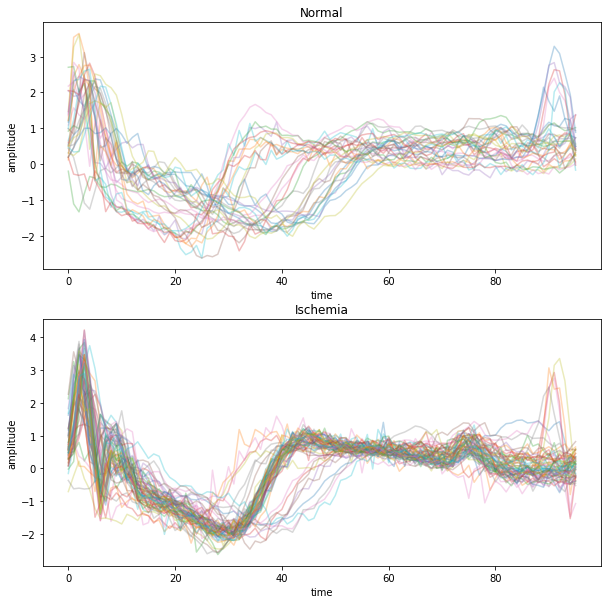

In [3]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(train.X[train.y.argmax(axis=1) == 0][:,:,0].T, alpha=0.3)
ax[0].set_title("Normal")
ax[0].set_xlabel("time")
ax[0].set_ylabel("amplitude")
ax[1].plot(train.X[train.y.argmax(axis=1) == 1][:,:,0].T, alpha=0.3)
ax[1].set_title("Ischemia")
ax[1].set_xlabel("time")
ax[1].set_ylabel("amplitude")
plt.show()

# Getting data ready for machine learning
Before the data is sent to the machine learning models we need to convert them from xarray DataArrays into standard numpy arrays. This can be done manually or using the helper function found in the dataset_creator module.

In [4]:
from src.utils.dataset_creator import da_to_numpy_for_ml
train_numpy, valid_numpy, test_numpy = da_to_numpy_for_ml(train, valid, test)

# Classify heartbeats
To be able to classify the heartbeats a model needs created and to be fitted
## Create model

In [5]:
# Load hyperparameters
hp_file = open(Path(api_dir) / "src/model/default_hyperparameters.json")
hp_dict = json.load(hp_file)

In [6]:
# define and fit classifier
output_dir = Path(api_dir) / "src/output"/ datetime.now().strftime("%Y-%m-%dT%H.%M.%S")
clf = Classifier(input_shape=train_numpy.X.shape, output_directory=output_dir, **hp_dict)

## Fitting model
To fit the model to the training set the `.fit_classifier` method is used.

In [7]:
clf.fit_classifier(train_numpy, test_numpy)

2021-11-09 16:09:20.564432: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
6/6 [==============================] - 2s 124ms/step - loss: 0.6971 - tp: 47.0000 - fp: 43.0000 - tn: 47.0000 - fn: 43.0000 - accuracy: 0.5222 - precision: 0.5222 - recall: 0.5222 - auc: 0.4447 - prc: 0.4705 - val_loss: 0.6673 - val_tp: 64.0000 - val_fp: 36.0000 - val_tn: 64.0000 - val_fn: 36.0000 - val_accuracy: 0.6400 - val_precision: 0.6400 - val_recall: 0.6400 - val_auc: 0.7588 - val_prc: 0.7647
Epoch 2/500
6/6 [==============================] - 0s 23ms/step - loss: 0.6905 - tp: 60.0000 - fp: 30.0000 - tn: 60.0000 - fn: 30.0000 - accuracy: 0.6667 - precision: 0.6667 - recall: 0.6667 - auc: 0.7399 - prc: 0.7564 - val_loss: 0.6795 - val_tp: 63.0000 - val_fp: 37.0000 - val_tn: 63.0000 - val_fn: 37.0000 - val_accuracy: 0.6300 - val_precision: 0.6300 - val_recall: 0.6300 - val_auc: 0.7526 - val_prc: 0.7201
Epoch 3/500
6/6 [==============================] - 0s 22ms/step - loss: 0.6873 - tp: 62.0000 - fp: 28.0000 - tn: 62.0000 - fn: 28.0000 - accuracy: 0.6889 - precision: 0.68

Epoch 21/500
6/6 [==============================] - 0s 24ms/step - loss: 0.2889 - tp: 76.0000 - fp: 14.0000 - tn: 76.0000 - fn: 14.0000 - accuracy: 0.8444 - precision: 0.8444 - recall: 0.8444 - auc: 0.9375 - prc: 0.9412 - val_loss: 0.4514 - val_tp: 78.0000 - val_fp: 22.0000 - val_tn: 78.0000 - val_fn: 22.0000 - val_accuracy: 0.7800 - val_precision: 0.7800 - val_recall: 0.7800 - val_auc: 0.8815 - val_prc: 0.8757
Epoch 22/500
6/6 [==============================] - 0s 21ms/step - loss: 0.2579 - tp: 80.0000 - fp: 10.0000 - tn: 80.0000 - fn: 10.0000 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9583 - prc: 0.9604 - val_loss: 0.4357 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.8954 - val_prc: 0.8865
Epoch 23/500
6/6 [==============================] - 0s 22ms/step - loss: 0.2573 - tp: 82.0000 - fp: 8.0000 - tn: 82.0000 - fn: 8.0000 - accuracy: 0.9111 - precision: 0.91

Epoch 41/500
6/6 [==============================] - 0s 24ms/step - loss: 0.1742 - tp: 83.0000 - fp: 7.0000 - tn: 83.0000 - fn: 7.0000 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9728 - prc: 0.9742 - val_loss: 0.4852 - val_tp: 81.0000 - val_fp: 19.0000 - val_tn: 81.0000 - val_fn: 19.0000 - val_accuracy: 0.8100 - val_precision: 0.8100 - val_recall: 0.8100 - val_auc: 0.9095 - val_prc: 0.9012
Epoch 42/500
6/6 [==============================] - 0s 24ms/step - loss: 0.1525 - tp: 85.0000 - fp: 5.0000 - tn: 85.0000 - fn: 5.0000 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9924 - prc: 0.9927 - val_loss: 0.4671 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9068 - val_prc: 0.9032
Epoch 43/500
6/6 [==============================] - 0s 23ms/step - loss: 0.1682 - tp: 82.0000 - fp: 8.0000 - tn: 82.0000 - fn: 8.0000 - accuracy: 0.9111 - precision: 0.9111 -

Epoch 61/500
6/6 [==============================] - 0s 31ms/step - loss: 0.0744 - tp: 86.0000 - fp: 4.0000 - tn: 86.0000 - fn: 4.0000 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9963 - prc: 0.9964 - val_loss: 0.5605 - val_tp: 82.0000 - val_fp: 18.0000 - val_tn: 82.0000 - val_fn: 18.0000 - val_accuracy: 0.8200 - val_precision: 0.8200 - val_recall: 0.8200 - val_auc: 0.9203 - val_prc: 0.9145
Epoch 62/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0851 - tp: 89.0000 - fp: 1.0000 - tn: 89.0000 - fn: 1.0000 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9991 - prc: 0.9991 - val_loss: 0.5375 - val_tp: 83.0000 - val_fp: 17.0000 - val_tn: 83.0000 - val_fn: 17.0000 - val_accuracy: 0.8300 - val_precision: 0.8300 - val_recall: 0.8300 - val_auc: 0.9195 - val_prc: 0.9071
Epoch 63/500
6/6 [==============================] - 0s 24ms/step - loss: 0.0875 - tp: 85.0000 - fp: 5.0000 - tn: 85.0000 - fn: 5.0000 - accuracy: 0.9444 - precision: 0.9444 -

Epoch 81/500
6/6 [==============================] - 0s 24ms/step - loss: 0.0283 - tp: 89.0000 - fp: 1.0000 - tn: 89.0000 - fn: 1.0000 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9996 - prc: 0.9996 - val_loss: 0.6639 - val_tp: 83.0000 - val_fp: 17.0000 - val_tn: 83.0000 - val_fn: 17.0000 - val_accuracy: 0.8300 - val_precision: 0.8300 - val_recall: 0.8300 - val_auc: 0.9227 - val_prc: 0.9141
Epoch 82/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0231 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.6459 - val_tp: 83.0000 - val_fp: 17.0000 - val_tn: 83.0000 - val_fn: 17.0000 - val_accuracy: 0.8300 - val_precision: 0.8300 - val_recall: 0.8300 - val_auc: 0.9234 - val_prc: 0.9145
Epoch 83/500
6/6 [==============================] - 0s 26ms/step - loss: 0.0223 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - pre

6/6 [==============================] - 0s 27ms/step - loss: 0.0097 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7354 - val_tp: 84.0000 - val_fp: 16.0000 - val_tn: 84.0000 - val_fn: 16.0000 - val_accuracy: 0.8400 - val_precision: 0.8400 - val_recall: 0.8400 - val_auc: 0.9262 - val_prc: 0.9178
Epoch 101/500
6/6 [==============================] - 0s 21ms/step - loss: 0.0111 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7510 - val_tp: 84.0000 - val_fp: 16.0000 - val_tn: 84.0000 - val_fn: 16.0000 - val_accuracy: 0.8400 - val_precision: 0.8400 - val_recall: 0.8400 - val_auc: 0.9185 - val_prc: 0.9065
Epoch 102/500
6/6 [==============================] - 0s 25ms/step - loss: 0.0090 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precis

6/6 [==============================] - 0s 21ms/step - loss: 0.0043 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.8216 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9127 - val_prc: 0.8974
Epoch 120/500
6/6 [==============================] - 0s 24ms/step - loss: 0.0052 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.8298 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9133 - val_prc: 0.8979
Epoch 121/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0047 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precis

6/6 [==============================] - 0s 22ms/step - loss: 0.0028 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.8644 - val_tp: 84.0000 - val_fp: 16.0000 - val_tn: 84.0000 - val_fn: 16.0000 - val_accuracy: 0.8400 - val_precision: 0.8400 - val_recall: 0.8400 - val_auc: 0.9210 - val_prc: 0.9091
Epoch 139/500
6/6 [==============================] - 0s 23ms/step - loss: 0.0030 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9242 - val_tp: 84.0000 - val_fp: 16.0000 - val_tn: 84.0000 - val_fn: 16.0000 - val_accuracy: 0.8400 - val_precision: 0.8400 - val_recall: 0.8400 - val_auc: 0.9052 - val_prc: 0.8871
Epoch 140/500
6/6 [==============================] - 0s 23ms/step - loss: 0.0026 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precis

6/6 [==============================] - 0s 20ms/step - loss: 0.0017 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9211 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9072 - val_prc: 0.8891
Epoch 158/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0015 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9195 - val_tp: 84.0000 - val_fp: 16.0000 - val_tn: 84.0000 - val_fn: 16.0000 - val_accuracy: 0.8400 - val_precision: 0.8400 - val_recall: 0.8400 - val_auc: 0.9074 - val_prc: 0.8893
Epoch 159/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0014 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precis

6/6 [==============================] - 0s 21ms/step - loss: 0.0010 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9714 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9072 - val_prc: 0.8892
Epoch 177/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0011 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9671 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9071 - val_prc: 0.8891
Epoch 178/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0010 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precis

6/6 [==============================] - 0s 21ms/step - loss: 7.4732e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9830 - val_tp: 84.0000 - val_fp: 16.0000 - val_tn: 84.0000 - val_fn: 16.0000 - val_accuracy: 0.8400 - val_precision: 0.8400 - val_recall: 0.8400 - val_auc: 0.9076 - val_prc: 0.8895
Epoch 196/500
6/6 [==============================] - 0s 22ms/step - loss: 9.0764e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9775 - val_tp: 84.0000 - val_fp: 16.0000 - val_tn: 84.0000 - val_fn: 16.0000 - val_accuracy: 0.8400 - val_precision: 0.8400 - val_recall: 0.8400 - val_auc: 0.9074 - val_prc: 0.8893
Epoch 197/500
6/6 [==============================] - 0s 21ms/step - loss: 8.5400e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 23ms/step - loss: 5.8815e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0243 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9069 - val_prc: 0.8889
Epoch 215/500
6/6 [==============================] - 0s 27ms/step - loss: 5.9646e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0218 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9074 - val_prc: 0.8893
Epoch 216/500
6/6 [==============================] - 0s 23ms/step - loss: 5.8638e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 22ms/step - loss: 5.2998e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0270 - val_tp: 84.0000 - val_fp: 16.0000 - val_tn: 84.0000 - val_fn: 16.0000 - val_accuracy: 0.8400 - val_precision: 0.8400 - val_recall: 0.8400 - val_auc: 0.9076 - val_prc: 0.8895
Epoch 234/500
6/6 [==============================] - 0s 23ms/step - loss: 5.2934e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0542 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9075 - val_prc: 0.8894
Epoch 235/500
6/6 [==============================] - 0s 24ms/step - loss: 4.7329e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 26ms/step - loss: 3.7436e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0688 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9075 - val_prc: 0.8894
Epoch 253/500
6/6 [==============================] - 0s 21ms/step - loss: 3.8227e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0645 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9076 - val_prc: 0.8895
Epoch 254/500
6/6 [==============================] - 0s 21ms/step - loss: 3.6540e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 22ms/step - loss: 3.2043e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0822 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9077 - val_prc: 0.8896
Epoch 272/500
6/6 [==============================] - 0s 24ms/step - loss: 3.0188e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0905 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9076 - val_prc: 0.8895
Epoch 273/500
6/6 [==============================] - 0s 24ms/step - loss: 3.1882e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 24ms/step - loss: 2.6450e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1054 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9078 - val_prc: 0.8897
Epoch 291/500
6/6 [==============================] - 0s 26ms/step - loss: 2.5581e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1070 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9079 - val_prc: 0.8897
Epoch 292/500
6/6 [==============================] - 0s 22ms/step - loss: 2.5261e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 22ms/step - loss: 2.1184e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1294 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9078 - val_prc: 0.8897
Epoch 310/500
6/6 [==============================] - 0s 22ms/step - loss: 2.0950e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1242 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9080 - val_prc: 0.8898
Epoch 311/500
6/6 [==============================] - 0s 22ms/step - loss: 2.1040e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 24ms/step - loss: 1.8360e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1516 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9083 - val_prc: 0.8904
Epoch 329/500
6/6 [==============================] - 0s 24ms/step - loss: 1.8050e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1517 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9083 - val_prc: 0.8904
Epoch 330/500
6/6 [==============================] - 0s 22ms/step - loss: 1.7899e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 24ms/step - loss: 1.5535e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1617 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9083 - val_prc: 0.8904
Epoch 348/500
6/6 [==============================] - 0s 22ms/step - loss: 1.5360e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1762 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9081 - val_prc: 0.8903
Epoch 349/500
6/6 [==============================] - 0s 22ms/step - loss: 1.5868e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 24ms/step - loss: 1.3572e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1801 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9087 - val_prc: 0.8908
Epoch 367/500
6/6 [==============================] - 0s 23ms/step - loss: 1.3169e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1764 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9090 - val_prc: 0.8913
Epoch 368/500
6/6 [==============================] - 0s 22ms/step - loss: 1.3339e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 22ms/step - loss: 1.2320e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1914 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9093 - val_prc: 0.8916
Epoch 386/500
6/6 [==============================] - 0s 24ms/step - loss: 1.2089e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1907 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9092 - val_prc: 0.8915
Epoch 387/500
6/6 [==============================] - 0s 24ms/step - loss: 1.2106e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 22ms/step - loss: 1.1271e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1985 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9093 - val_prc: 0.8916
Epoch 405/500
6/6 [==============================] - 0s 23ms/step - loss: 1.1351e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1962 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9094 - val_prc: 0.8917
Epoch 406/500
6/6 [==============================] - 0s 23ms/step - loss: 1.1294e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 22ms/step - loss: 1.0536e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2073 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9092 - val_prc: 0.8915
Epoch 424/500
6/6 [==============================] - 0s 22ms/step - loss: 1.0514e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2069 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9092 - val_prc: 0.8915
Epoch 425/500
6/6 [==============================] - 0s 24ms/step - loss: 1.0552e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 22ms/step - loss: 1.0117e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2104 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9094 - val_prc: 0.8917
Epoch 443/500
6/6 [==============================] - 0s 23ms/step - loss: 1.0112e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2105 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9094 - val_prc: 0.8917
Epoch 444/500
6/6 [==============================] - 0s 22ms/step - loss: 1.0136e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 23ms/step - loss: 9.7683e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2181 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9090 - val_prc: 0.8913
Epoch 462/500
6/6 [==============================] - 0s 25ms/step - loss: 9.7152e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2177 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9092 - val_prc: 0.8915
Epoch 463/500
6/6 [==============================] - 0s 23ms/step - loss: 9.6761e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 21ms/step - loss: 9.4187e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2182 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9094 - val_prc: 0.8917
Epoch 481/500
6/6 [==============================] - 0s 25ms/step - loss: 9.4164e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2185 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9092 - val_prc: 0.8915
Epoch 482/500
6/6 [==============================] - 0s 24ms/step - loss: 9.3955e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 24ms/step - loss: 9.2359e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2236 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9092 - val_prc: 0.8915
Epoch 500/500
6/6 [==============================] - 0s 24ms/step - loss: 9.2330e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2223 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9093 - val_prc: 0.8916


## Classification and evaluation
After training the network its possible to use the model on new data.
To apply the model on some data the `model.predict` method is used.
It is also possible to evaluate model performance using `model.evaluate`.

In [24]:
# make classification
y_pred = clf.model.predict(x=test_numpy.X)

In [25]:
# eval classifier
results = clf.model.evaluate(x=test_numpy.X, y=test_numpy.y, return_dict=True)
pd.DataFrame.from_dict(results, orient='index').T

4/4 [==============================] - 0s 6ms/step - loss: 1.2223 - tp: 86.0000 - fp: 14.0000 - tn: 86.0000 - fn: 14.0000 - accuracy: 0.8600 - precision: 0.8600 - recall: 0.8600 - auc: 0.9093 - prc: 0.8916


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,1.222311,86.0,14.0,86.0,14.0,0.86,0.86,0.86,0.9093,0.891596


# Explain classification
It might also be of interest, to get insight on what the network based its classification on.
Here we can use an explainer such as the SHAP gradient explainer.

In [10]:
is_correct_classification = (y_pred.argmax(axis=1) == test_numpy.y.argmax(axis=1))
ex_classification = explain_samples(explainer=ShapGradientExplainer(),
                                    model=clf.model,
                                    X_reference=train_numpy.X,
                                    X_to_explain=test_numpy.X[is_correct_classification, :, :])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


## Visualization of explanations
In order to present the sample explanation we can make a plot of the signal with a coloured overlay.
The overlay color is determined by the shap value.

In [21]:
def plot_importance(X_to_explain, y_pred, explanation):
    cmap = mpl.colors.LinearSegmentedColormap.from_list('shap', [mpl.cm.cool(0), (1, 1, 1, 1), mpl.cm.cool(256)],N=256)
    
    fig, ax = plt.subplots(figsize=(7,5))  
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 0), :, :].mean(axis=0), linewidth=3, c="b")
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 1), :, :].mean(axis=0), linewidth=3, c="r")
    
    extent = [0, len(X_to_explain[0]), ax.get_ylim()[0], ax.get_ylim()[1]]
    im1 = ax.imshow(explanation[0].mean(axis=0).T, cmap=cmap, aspect="auto", alpha=0.8, extent=extent)  
    cbar1 = fig.colorbar(im1, ax=ax)
    cbar1.set_label("SHAP values (relative)")

    ax.set_xlabel("samples")
    ax.set_xlabel("amplitude")
    ax.set_title("Explanations of Classifications")
    ax.legend(["Mean normal","Mean ischemia"])

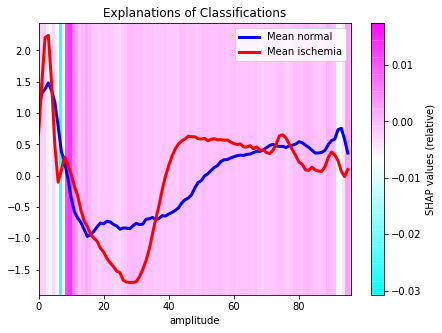

In [26]:
plot_importance(X_to_explain = test_numpy.X, y_pred = y_pred, explanation = ex_classification)
